<a href="https://colab.research.google.com/github/sm354/COL870-Assignment-1/blob/main/2_2_COMPLETE_bILSTM_CRF_glove_CHARLEVEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Expname = "BiLSTM_crf_char_glove"
pre_embeddings= "glove" # glove or random
rootpath = "/content/drive/MyDrive/Q2_DL/Experiments/"

!pip install seqeval

import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.utils.data import Dataset, DataLoader, TensorDataset
import io
import sklearn
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import seqeval
from seqeval.metrics import accuracy_score as seq_accuracy_score
from seqeval.metrics import classification_report as seq_classification_report
from seqeval.metrics import f1_score as seq_f1_score

if torch.cuda.is_available():  
  device = "cuda:0" 
else:  
  device = "cpu"  


from google.colab import drive
drive.mount('/content/drive')


'''Helper Functions'''
# reading text file in python and making list of sentences (list of lists) and list of tags(list of lists)
def load_data(datapath, buildvocab_tags= True, vocab = None, nertags = None):
    if(buildvocab_tags == True):
        all_words = []
        all_tags = []
        with open(datapath) as f:
            lines = f.readlines()
            sent_num = 0
            for line in lines[1:]: #1: so that the first blank line isn't taken into account
                if(line == "\n"):
                    sent_num+=1
                else:
                    line_sep = line.split(sep = " ")
                    all_words.append(line_sep[0])
                    all_tags.append(line_sep[3][:-1])
                    
        words = list(set(all_words))
        tags = list(set(all_tags))

        vocab = {}
        vocab['<pad>'] = 0 # for padding input sequences
        vocab['<oov>'] = 1
        for i, word in enumerate(words):
            vocab[word] = i+2
            
        nertags = {}
        nertags['padtag'] = 0
        for i,nertag in enumerate(tags):
            nertags[nertag] = i+1

    train_sent = []
    train_tags = []
    with open(datapath) as f:
        lines = f.readlines()
        sent_num = 0
        sentence = []
        tag = []
        for line in lines[1:]: #1: so that the first blank line isn't taken into account
            if(line == "\n"):
                sent_num+=1
                train_sent.append(sentence)
                train_tags.append(tag)
                sentence = []
                tag = []
            else:
                line_sep = line.split(sep = " ")
                if(line_sep[0] in vocab.keys()):
                    sentence.append(vocab[line_sep[0]])
                else:
                    sentence.append(vocab['<oov>'])
                    
                tag.append(nertags[line_sep[3][:-1]])

    # padding the sentences at the end
    seq_maxlen = max(len(x) for x in train_sent)
    x_lengths = [len(x) for x in train_sent]
    Xtrain = []
    Ytrain = []
    for sent, tags in zip(train_sent, train_tags):
        length_toappend = seq_maxlen - len(sent)
        Xtrain.append(sent+[0]*length_toappend)
        Ytrain.append(tags+[0]*length_toappend)


    Xtrain = torch.Tensor(Xtrain)
    Ytrain = torch.Tensor(Ytrain)
    x_lengths = torch.Tensor(x_lengths)
    # print(Xtrain.shape, Ytrain.shape, x_lengths.shape)
    
    return Xtrain, Ytrain, x_lengths, vocab, nertags

def get_mask(x, xlengths):
    bin_mask = []
    for i in range(xlengths.shape[0]):
        bin_mask.append([1]*int(xlengths[i].item())+[0]*int((x.shape[1] - xlengths[i].item())))
    return torch.tensor(bin_mask)

def load_char_data(words, charvocab):
    train_char_sent = []
    train_char_label = []
    for word in words:
        chars = []
        char_labels = []

        word_sep = list(word)
        for c in word_sep[:-1]:
            if (c in charvocab.keys()):
                chars.append(charvocab[c])
            else:
                chars.append(charvocab['<oovchar>'])
        for c in word_sep[1:]:
            if (c in charvocab.keys()):
                char_labels.append(charvocab[c])
            else:
                char_labels.append(charvocab['<oovchar>'])
        
        train_char_sent.append(chars)
        train_char_label.append(char_labels)

    # padding the char_sents at the end
    seq_maxlen = max(len(x) for x in train_char_sent)
    x_lengths_char = [len(x) for x in train_char_sent]
    Xtrain_char = []
    Ytrain_char = []
    for char_sent, char_label in zip(train_char_sent, train_char_label):
        length_toappend = seq_maxlen - len(char_sent)
        Xtrain_char.append(char_sent+[0]*length_toappend)
        Ytrain_char.append(char_label+[0]*length_toappend) # 0 is padchar


    Xtrain_char = torch.Tensor(Xtrain_char)
    Ytrain_char = torch.Tensor(Ytrain_char)
    x_lengths_char = torch.Tensor(x_lengths_char)
    # print(Xtrain.shape, Ytrain.shape, x_lengths.shape)
    
    return Xtrain_char, Ytrain_char, x_lengths_char

def pad_chars(topadlist, maxlen):
    topadlist = topadlist + [0]*(maxlen-len(topadlist))

    return topadlist

def make_id2word_charvocab(vocab, charvocab):
    max_charlen = max(len(word) for word in vocab.keys())
    word_charlevel_vocab = {}
    wordid2wordlen = {}
    for word in vocab.keys():
        word_charlevel_vocab[vocab[word]] = [charvocab[w] if w in charvocab.keys() else charvocab['<oovchar>'] for w in word]
        word_charlevel_vocab[vocab[word]] = pad_chars(word_charlevel_vocab[vocab[word]], max_charlen)

        wordid2wordlen[vocab[word]] = len(word)
        # word_charlevel_vocab[vocab[word]] = word_charlevel_vocab[vocab[word]].extend([charvocab['<padchar>']]*(max_charlen-len(word_charlevel_vocab[vocab[word]])))
    return word_charlevel_vocab, wordid2wordlen


def load_char_level(X, wordid2word_charlevel_vocab, wordid2wordlen):
    #X is of shape (no.of.sentences, 104)
    Xcharlevel = [] # will finally be fo shape (total.sentences, max_sent.len, )
    Xcharlevel_lengths = []
    for i in range(X.shape[0]):
        sentence = []
        wordlengths = []
        for j in range(X.shape[1]):
            sentence.append(torch.tensor([wordid2word_charlevel_vocab[int(X[i, j].item())]]))
            wordlengths.append(wordid2wordlen[int(X[i, j].item())])
            # sentences = pad_sequence(sentences)
        # print(i)
        Xcharlevel_lengths.append(wordlengths)
        Xcharlevel.append(torch.stack(sentence))
    
    return torch.squeeze(torch.stack(Xcharlevel)), torch.tensor(Xcharlevel_lengths)

def get_charvocab(vocab):
    # using vocab make charvocab
    words = list(vocab.keys())
    characters = [char for word in words for char in word]
    characters = list(set(characters))
    char_vocab = {}
    char_vocab["<padchar>"] = 0
    char_vocab["<oovchar>"] = 1
    for i, char in enumerate(characters):
        char_vocab[char] = i+2

    return char_vocab


"""### Training Data
### using dataloader to make data batches"""

traindatapath = "/content/drive/MyDrive/Q2_DL/train.txt"
devdatapath = "/content/drive/MyDrive/Q2_DL/dev.txt"

Xtrain, Ytrain, x_trainlengths, vocab, nertags = load_data(traindatapath, buildvocab_tags=True)
Xdev, Ydev, x_devlengths, _, _ = load_data(devdatapath, buildvocab_tags=False, vocab = vocab, nertags = nertags)

bin_mask_train, bin_mask_dev = get_mask(Xtrain, x_trainlengths), get_mask(Xdev, x_devlengths)

# Character Level training data making
# make vocabulary of characters from train vocabulary
char_vocab = get_charvocab(vocab)
wordid2word_charlevel_vocab, wordid2wordlen = make_id2word_charvocab(vocab, char_vocab) # of the form {word:[1,2,3,4]}, {wordnum:wordlen}
#make char level train data for the char embeddings 
Xtrain_char, xlength_char = load_char_level(Xtrain, wordid2word_charlevel_vocab, wordid2wordlen)
#finally make the dataloader for train
traindataset = TensorDataset(Xtrain, Xtrain_char, Ytrain, x_trainlengths, xlength_char, bin_mask_train)
Trainloader = DataLoader(traindataset, batch_size= 128, shuffle=True)


# Character Level validation data making
Xdev_temp, Ydev_temp, x_devlengths_temp, devvocab, devnertags = load_data(devdatapath, buildvocab_tags=True)
wordid2word_charlevel_vocab_dev, wordid2wordlen_dev = make_id2word_charvocab(devvocab, char_vocab) # of the form {word:[1,2,3,4]}, {wordnum:wordlen}
#make char level train data for the char embeddings 
Xdev_char, xdevlength_char = load_char_level(Xdev_temp, wordid2word_charlevel_vocab_dev, wordid2wordlen_dev)
#finally make the dataloader for train
devdataset = TensorDataset(Xdev, Xdev_char, Ydev, x_devlengths, xdevlength_char, bin_mask_dev)
Devloader = DataLoader(devdataset, batch_size= 128, shuffle=True)

# LOAD EMBEDDINGS
embedding_size = 100
if(pre_embeddings == "glove"):
    gloveembeddings_index = {}
    with io.open("/content/drive/MyDrive/Q2_DL/glove.6B.100d.txt", encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:],dtype='float32')
            gloveembeddings_index[word] = coefs

    #using vocab and Xtrain, Xvalid, get pretrained glove word embeddings
    glove_embeds = np.zeros((len(vocab), embedding_size))
    for word in vocab.keys():
        if(word in gloveembeddings_index.keys()):
            # for the pad word let theembedding be all zeros
            glove_embeds[vocab[word]] = gloveembeddings_index[word]
        else:
            glove_embeds[vocab[word]] = np.random.randn(embedding_size)
    word_embeds = torch.Tensor(glove_embeds)
    # print(glove_embeds.shape) # shape (vocablength , embedding dim)

if(pre_embeddings == "random"):
    num_words = len(vocab)
    word_embeds = torch.rand(num_words, embedding_size)

# hence we get word_embeds which we could use afterwards


# character level onehot embeddings and important classes for performance metrics
char_onehot = torch.eye(len(char_vocab))
imp_classes = [nertags[tag] for tag in nertags.keys()]
imp_classes.remove(nertags['padtag'])
imp_classes.remove(nertags['O'])

     |████████████████████████████████| 51kB 5.5MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=4d9607d49ab8014d4a435bf41eeb53602c0dcdc3ccb1d066c009e112c7926ccd
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval
Mounted at /content/drive


In [ ]:
"""### CRF MODULE"""

class CRFmodule(nn.Module):
    def __init__(self, numclass):
        super(CRFmodule, self).__init__()
        # numtags is representing the start position and numtags+1 the end position/id of the tags
        random_transition = torch.zeros(numclass+2, numclass+2)
        random_transition[numclass, :], random_transition[:, numclass+1] = -10000., -10000.
        self.transmat = nn.Parameter(random_transition) # learnable matrix shape (num_classes, numclasses) including start and stop tag
        self.startid = numclass
        self.endid = numclass+1
    
    def forward(self, Ylstm, Ymask):
        # y of shape (batchsize, seq_len, num_classes) num_classes = 18 when start and stop are not included but pad is included

        # use viterbi algorithm to decode the correct sequence, given "y" sequence of tags 
        # from the bilstm and given the transition matrix that we have

        # VITERBI ALGORITHM - output = decoded_tag_sequence of shape (batchsize, seqlen)
        forward_scores = self.init_for_scores(Ylstm)
        backtrack = []
        for i in range(Ylstm.shape[1]):
            for_scr_temp = forward_scores.view((Ylstm.shape[0], 1, Ylstm.shape[2])) 
            forward_transition_score_word = self.transmat + for_scr_temp 

            max_indices = torch.argmax(forward_transition_score_word, dim = 2)
            forward_transition_score_word , _ = torch.max(forward_transition_score_word, dim = 2) # max_indices of shape (batches, C)
            backtrack.append(max_indices)
            unaryscore_word = Ylstm[:, i]#.view(Ylstm.shape[0], 1, Ylstm.shape[2]) # unary_score_word  of shape (batchsize, 1, num_classes)
            forward_transition_score_word = forward_transition_score_word + unaryscore_word
            
            forward_scores = forward_transition_score_word * Ymask[:, i].view(Ylstm.shape[0], 1) + (1 - Ymask[:, i].view(Ylstm.shape[0], 1)) * forward_scores

        end_score = forward_scores + self.transmat[self.endid] #shape will be (batches, num_classes)
        max_index = torch.argmax(end_score, dim = 1).view(Ylstm.shape[0], 1) # shape is (Batch, 1)
        # print(max_index.shape)
        decoded_path = [max_index] 

        for index in backtrack[::-1]: #index is of shape (batches, numclasses)
            # print(max_index)
            max_index = torch.gather(index, 1, max_index).view(Ylstm.shape[0], 1)
            decoded_path.append(max_index)
        decoded_path = decoded_path[::-1][1:] #remove the start word
        # print(decoded_path)
        decoded_path = torch.cat(decoded_path, dim = 1)
        return decoded_path

    def crfloss(self, Ylstm, Ytrue, Ymask):
        # loss is the negative los likelyhood = partition function - numerator
        partition, numerator  = self.get_partition_numerator(Ylstm, Ytrue, Ymask) #numerator means in log space here
        loss = partition - numerator
        # print(numerator.mean(), partition.mean())
        return loss.mean()
    
    def get_partition_numerator(self, Ylstm, Ytrue, Ymask):
        # calculate the partition function
        forward_scores = self.init_for_scores(Ylstm)
        for i in range(Ylstm.shape[1]):
            unaryscore_word = Ylstm[:, i].view(Ylstm.shape[0], Ylstm.shape[2], 1) # shape is now (batchsize, num_classes, 1)
            unary_transition_score_word = unaryscore_word + self.transmat.view(1, Ylstm.shape[2], Ylstm.shape[2])
            temp_score = torch.logsumexp(unary_transition_score_word + forward_scores.view(Ylstm.shape[0], 1, Ylstm.shape[2]), dim = 2)
            forward_scores = temp_score * (Ymask[:, i].view(Ylstm.shape[0], 1)) + (1- Ymask[:, i].view(Ylstm.shape[0], 1)) * forward_scores

        end_score_ = forward_scores + self.transmat[self.endid].view(1, Ylstm.shape[2])
        forward_scores = torch.logsumexp(end_score_, dim = 1)

        # calculate the score using Ylstm, Ytrue - shapes (batch, seqlen, numclass), (batch, seqlen)
        # Ytrue is the tags of shape (Batch, seqlen), we concatenate start tag with this
        Ytrue_mod = self.concat_start_tag_begin(Ytrue)
        unary_scores = self.get_emission_score(Ylstm, Ytrue)
        transition_scores = self.get_transition_score(Ytrue_mod)
        total_score = ((unary_scores+transition_scores)*Ymask).sum(1) # sum alon the length dimension, finally get a (batch, 1) dimesnion vector
        end_score = self.get_stop_score(Ytrue_mod)
        numerator = total_score + end_score # shape is (batchsize)
        # we have the numerator in log space
        return forward_scores, numerator
        
    def init_for_scores(self, Ylstm):
        forward_scores = torch.ones((Ylstm.shape[0], Ylstm.shape[2]))*-10000.
        forward_scores = forward_scores.long().to(Ylstm.device)
        forward_scores[:, self.startid] = 0.
        return forward_scores

    def get_stop_score(self, Ytrue):
        from_ = Ytrue[:, -1].long()
        to_ = self.endid
        stop_scores = self.transmat[to_, from_]
        return stop_scores

    def concat_start_tag_begin(self, Ytrue):
        starttags_batch = torch.full((Ytrue.shape[0], 1), fill_value = self.startid).to(Ytrue.device)
        Ytrue = torch.cat((starttags_batch, Ytrue), dim = 1)
        return Ytrue

    def get_emission_score(self, Ylstm, Ytrue):
        shape = Ytrue.shape
        truetags = Ytrue.view(shape[0], shape[1], 1)
        emission_scores = Ylstm.gather(dim=2, index=truetags.type(torch.int64).to(Ylstm.device)).view(shape[0], shape[1])
        return emission_scores
    
    def get_transition_score(self, Ytrue):
        from_ = Ytrue[:, :-1].long()
        to_ = Ytrue[:, 1:].long()
        transition_scores = self.transmat[to_, from_]
        return transition_scores # of shape (batch, seqlen)

"""# LSTM model for character **level**
"""
class forLSTM(nn.Module):
    def __init__(self, embedding_size, hidden_size, pretr_char_embed):
        super(forLSTM, self).__init__()
        self.charembed = nn.Embedding.from_pretrained(pretr_char_embed, freeze = False) #size of pretrained = (totalchars,embedding size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, bidirectional = True, batch_first = True)

    def forward(self, xchar, xlength_char):
        #xchar is of shape(batchsize, seqlen_maxinbatch, maxwordlen-ie max char = 6)

        shape = xchar.shape
        xchar = xchar.view(-1, shape[2])
        xlength_char = xlength_char.view(-1)
        input = pack_padded_sequence(xchar, xlength_char.cpu(), batch_first=True, enforce_sorted=False)
        input, _ = pad_packed_sequence(input, batch_first=True)
        embed = self.charembed(input)
        _, (h,_) = self.lstm(embed) #h is of size (2, 128*maxno. of words in a sentence in the batch, 25)
        h = h.view(h.shape[1], 50)
        h = h.view(shape[0], shape[1], 50)
        return h

"""# BiLSTM Model"""
class BiLSTM(nn.Module):
    def __init__(self, embedding_size, hidden_size, total_words, num_class, pretrained = False, pretrained_embed = None, char_embed_size = 0, pretr_char_embed = None):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.wordembed = nn.Embedding.from_pretrained(pretrained_embed, freeze = False)
        self.for_charembed = forLSTM(embedding_size = char_embed_size, hidden_size = 25, pretr_char_embed = pretr_char_embed)
        self.dropout = nn.Dropout(p = 0.5)
        self.bilstm = nn.LSTM(embedding_size + 50,hidden_size, bidirectional = True, batch_first = True)
        self.linear = nn.Linear(2*hidden_size, num_class+2) # 2 because forward and backward concatenate, +2 for feeding it into the crf layer, ie for start stop tags
        self.crfmodule = CRFmodule(num_class)

    # def forward(self, x, xchar, xlengths, xlength_char):
    #     x = pack_padded_sequence(x, xlengths.cpu(), batch_first=True, enforce_sorted=False)
    #     x, _ = pad_packed_sequence(x, batch_first=True)

    #     xlength_char = pack_padded_sequence(xlength_char, xlengths.cpu(), batch_first=True, enforce_sorted=False)
    #     xlength_char, _ = pad_packed_sequence(xlength_char, batch_first=True, padding_value = len("<pad>")) 
    #     # above this line padding value is taken as len of pad word becasue that is what we pad sentences 
    #     # with hance at a character level it should be the length

    #     xchar = pack_padded_sequence(xchar, xlengths.cpu(), batch_first=True, enforce_sorted=False)
    #     xchar, _ = pad_packed_sequence(xchar, batch_first=True)

    #     word_embedding = self.wordembed(x) # x is of size(batchsize, seq_len), wordembed is of size (batchsize, seq_len, embedding_size = 100)
    #     forwardchar= self.for_charembed(xchar, xlength_char) #forwardchar and backwardchar would be of size (batchsize, seqlen. embedding_size = 25each) 
    #     word_embedding = torch.cat((word_embedding, forwardchar), dim = 2)

    #     word_embedding = self.dropout(word_embedding) #dropout
    #     out, (h,c) = self.bilstm(word_embedding) #'out' has dimension(batchsize, seq_len, 2*hidden_size)

    #     out = self.linear(out) #now 'out' has dimension(batchsize, seq_len, num_class)
    #     out = out.view(-1, out.shape[2]) # shape (128*seqlen, 18)
    #     out = F.log_softmax(out, dim=1) # take the softmax across the dimension num_class, 'out' has dimension(batchsize, seq_len, num_class)
    #     return out
        
    def forward(self, x, xchar, xlengths, xlength_char, xmask): 
        xmask = xmask.to(x.device)
        ylstm, xmask = self.lstmoutput(x, xchar, xlengths, xlength_char, xmask)
        out = self.crfmodule(ylstm, xmask) #out of shape (batch, seqlen)
        return out

    def loss(self, x, xchar, xlengths, xlength_char, ytrue, xmask):
        xmask = xmask.to(x.device)

        '''calls the loss function of the crf for getting the negative log likelyhood loss'''
        ylstm, xmask = self.lstmoutput(x, xchar, xlengths, xlength_char, xmask)
        loss = self.crfmodule.crfloss(ylstm, ytrue, xmask)
        return loss

    def lstmoutput(self, x, xchar, xlengths, xlength_char, xmask):
        x = pack_padded_sequence(x, xlengths.cpu(), batch_first=True, enforce_sorted=False)
        x, _ = pad_packed_sequence(x, batch_first=True)

        xlength_char = pack_padded_sequence(xlength_char, xlengths.cpu(), batch_first=True, enforce_sorted=False)
        xlength_char, _ = pad_packed_sequence(xlength_char, batch_first=True, padding_value = len("<pad>")) 
        # above this line padding value is taken as len of pad word becasue that is what we pad sentences 
        # with hance at a character level it should be the length

        xchar = pack_padded_sequence(xchar, xlengths.cpu(), batch_first=True, enforce_sorted=False)
        xchar, _ = pad_packed_sequence(xchar, batch_first=True)

        xmask = pack_padded_sequence(xmask, xlengths.cpu(), batch_first=True, enforce_sorted=False)
        xmask, _ = pad_packed_sequence(xmask, batch_first=True)

        word_embedding = self.wordembed(x) # x is of size(batchsize, seq_len), wordembed is of size (batchsize, seq_len, embedding_size = 100)
        forwardchar= self.for_charembed(xchar, xlength_char) #forwardchar and backwardchar would be of size (batchsize, seqlen. embedding_size = 25each) 
        word_embedding = torch.cat((word_embedding, forwardchar), dim = 2)

        word_embedding = self.dropout(word_embedding) # dropout
        out, (h,c) = self.bilstm(word_embedding) # 'out' has dimension(batchsize, seq_len, 2*hidden_size)
        out = self.linear(out) # now 'out' has dimension(batchsize, seq_len, num_class+2)

        return out, xmask




In [ ]:
model = BiLSTM(embedding_size = 100, hidden_size = 100, total_words = len(vocab), num_class = 18, pretrained = True, pretrained_embed = word_embeds, char_embed_size = len(char_vocab), pretr_char_embed = char_onehot).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3) 
lossfunction = nn.CrossEntropyLoss()


# print(model)
def performance(y, ypred, nertags):
    y = y.numpy()
    ypred = ypred.numpy()
    mask = (y != nertags['padtag']) * (y != nertags['O'])
    y = y*mask
    ypred = ypred*mask
    acc = ((y==ypred)*mask).sum()/mask.sum()
    microf1 = f1_score(y, ypred, labels = imp_classes, average='micro')
    macrof1 = f1_score(y, ypred, labels = imp_classes, average='macro')
    return acc, microf1, macrof1

def validate(model, loader):
    with torch.no_grad():
        validloss = 0
        acc = 0
        microf1 = 0
        macrof1 = 0
        i = 0
        for step, (X, Xchar, Y, xlen, xlen_char, Xmask) in enumerate(loader):
            Y = pack_padded_sequence(Y, xlen, batch_first=True, enforce_sorted=False)
            Y, _ = pad_packed_sequence(Y, batch_first=True)
            ypred = model(X.long().to(device), Xchar.to(device), xlen.to(device), xlen_char.to(device), Xmask)#.permute(0, 2, 1)
            vloss = model.loss(X.long().to(device), Xchar.to(device), xlen.to(device), xlen_char.to(device), Y, Xmask)
            validloss+=vloss.item()
            acc_, microf1_, macrof1_ = performance(Y.view(-1), ypred.to('cpu').view(-1), nertags)
            acc+=acc_
            microf1 += microf1_
            macrof1 += macrof1_
            i+=1

    return validloss/i, acc/i, microf1/i, macrof1/i



In [ ]:
trainlosslist = []
trainacclist = [] #accuracy except pad, O
trainmicrof1list = []
trainmacrof1list = []


validlosslist = []
valacclist = []
valmicrof1list = []
valmacrof1list = []


# Model is ready now we have to train using cross entropy loss
num_epochs = 50
# validloss = []
model.train()
for epoch in range(num_epochs):
    if(epoch == 35):
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
    
    totalloss, acc, microf1, macrof1 = 0, 0, 0, 0
    for step, (Xbatch , Xchar ,Ybatch, xbatch_len, xlength_char, xbatch_mask) in enumerate(Trainloader):
        #make gradients 0
        optimizer.zero_grad()

        Ybatch = pack_padded_sequence(Ybatch, xbatch_len, batch_first=True, enforce_sorted=False)
        Ybatch, y_lengths = pad_packed_sequence(Ybatch, batch_first=True)

        #get output from model and claculate loss
        ypred = model(Xbatch.long().to(device), Xchar.to(device), xbatch_len.to(device), xlength_char.to(device), xbatch_mask)#.permute(0, 2, 1)
        loss = model.loss(Xbatch.long().to(device), Xchar.to(device), xbatch_len.to(device), xlength_char.to(device), Ybatch, xbatch_mask)
        
        acc_, microf1_, macrof1_ = performance(Ybatch.view(-1), ypred.to('cpu').view(-1), nertags)
        acc+= acc_
        microf1+=microf1_
        macrof1+=macrof1_
        if(step%20 == 0 and step !=0):
            print("training accuracy = {}, microF1 = {}, macroF1 = {}".format(acc/(step+1), microf1/(step+1), macrof1/(step+1)))
        
        totalloss += loss.item()

        #backward and step
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5) # clip gradient to 5
        optimizer.step()
    
    trainlosslist.append(totalloss/(step+1))
    trainacclist.append(acc/(step+1))
    trainmicrof1list.append(microf1/(step+1))
    trainmacrof1list.append(macrof1/(step+1))

    # model validation loss and scheduler step for learning rate change if required
    val_loss, val_acc, val_microf1, val_macrof1  = validate(model, Devloader)
    validlosslist.append(val_loss)
    valacclist.append(val_acc)
    valmicrof1list.append(val_microf1)
    valmacrof1list.append(val_macrof1)
    
    # scheduler.step(val_loss)
    print('\nepoch = {}, training_loss = {}, validation_loss ={}, training_acc = {}, validation_acc ={}'.format(epoch, trainlosslist[-1], validlosslist[-1], trainacclist[-1], valacclist[-1]))        
        

model.eval()

import os
if not os.path.exists(rootpath):
    os.mkdir(rootpath)

if not os.path.exists(rootpath+Expname):
    os.mkdir(rootpath+Expname)


def SavePlots(y1, y2, metric, rootpath, Expname):
    try:
        plt.clf()
    except Exception as e:
        pass
    """y2 should be validation"""
    epochs=np.arange(1,len(y1)+1,1)
    plt.title(Expname + " " + metric + " plot")
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.plot(epochs,y1,label='Training %s'%metric, linewidth = 2)
    plt.plot(epochs,y2,label='Validation %s'%metric, linewidth = 2)
    if(metric == "Loss"):
        ep=np.argmin(y2)
    elif(metric != "Loss"):
        ep =np.argmax(y2)
    plt.plot(ep+1,y2[ep],'r*',label='bestvalue@(%.i,%.2f)'%(ep+1,y2[ep]))
    plt.grid()
    plt.legend()
    plt.savefig(rootpath+Expname+"/{}".format(metric), dpi=300)

SavePlots(trainlosslist, validlosslist, "Loss", rootpath, Expname)
SavePlots(trainacclist, valacclist, "Accuracy", rootpath, Expname)
SavePlots(trainmicrof1list, valmicrof1list, "Micro F1", rootpath, Expname)
SavePlots(trainmacrof1list, valmacrof1list, "Macro F1", rootpath, Expname)

#make id2tag
id2tag = {}
for tag in nertags.keys():
    if(tag == 'padtag'):
        id2tag[nertags[tag]] = 'O' # because we dont want the model to predict 'padtag' tags
    else:
        id2tag[nertags[tag]] = tag


def final_metrics(model, loader):
    y_predicted = []
    y_true = []
    with torch.no_grad():
        for step, (X, Xchar, Y, xlen, xlen_char, xmask) in enumerate(loader):
            Y = pack_padded_sequence(Y, xlen, batch_first=True, enforce_sorted=False)
            Y, _ = pad_packed_sequence(Y, batch_first=True)
            ypred = model(X.long().to(device), Xchar.to(device), xlen.to(device), xlen_char.to(device), xmask)#.permute(0, 2, 1)
            # ypred = torch.argmax(ypred.to('cpu'), dim = 1)
            ypred = ypred.view(Y.shape[0], -1)
            # print(ypred.shape)

            y_predicted.append(ypred)
            y_true.append(Y)

    y_predicted_list = []
    y_true_list = []
    for i in range(len(y_predicted)):
        for j in range(y_predicted[i].shape[0]):
            sent_pred = []
            sent_true = []
            for x in range(y_predicted[i].shape[1]):
                sent_pred.append(id2tag[int(y_predicted[i][j, x])])
                sent_true.append(id2tag[int(y_true[i][j, x])])
            y_predicted_list.append(sent_pred)
            y_true_list.append(sent_true)
    # print(y_predicted_list[0:5])
    # print(y_true_list[0:5])
    return seq_f1_score(y_true_list, y_predicted_list), seq_accuracy_score(y_true_list, y_predicted_list), seq_classification_report(y_true_list, y_predicted_list, digits = 3)
    #CONVERTING y_predicted and y_true lists into tag list
    # return y_predicted, y_true


# calculate the final metrics usign seq eval
# TRAINING DATA
loader_train = DataLoader(traindataset, batch_size= 1, shuffle=False)
train_f1_conll, train_acc_conll, train_classif_report = final_metrics(model, loader_train)

# VALIDATION DATA
loader_valid = DataLoader(devdataset, batch_size= 1, shuffle=False)
valid_f1_conll, valid_acc_conll, valid_classif_report = final_metrics(model, loader_valid)

print("PERFORMANCE ON Train DATA")
print('MicroF1 = {} '.format(train_f1_conll))
print('Accuracy = {}'.format(train_acc_conll))
print('------------Classification Report-------------')
print(train_classif_report)

print("PERFORMANCE ON Validation DATA")
print('MicroF1 = {} '.format(valid_f1_conll))
print('Accuracy = {}'.format(valid_acc_conll))
print('------------Classification Report-------------')
print(valid_classif_report)



#Test DATASET
testdatapath = "/content/drive/MyDrive/Q2_DL/test.txt"
char_vocab = get_charvocab(vocab)
Xtest, Ytest, x_testlengths, _, _ = load_data(testdatapath, buildvocab_tags=False, vocab = vocab, nertags = nertags)
bin_mask_test =  get_mask(Xtest, x_testlengths)

Xtest_temp, Ytest_temp, x_testlengths_temp, testvocab, testnertags = load_data(testdatapath, buildvocab_tags=True)
wordid2word_charlevel_vocab_test, wordid2wordlen_test = make_id2word_charvocab(testvocab, char_vocab) # of the form {word:[1,2,3,4]}, {wordnum:wordlen}
#make char level train data for the char embeddings 
Xtest_char, xtestlength_char = load_char_level(Xtest_temp, wordid2word_charlevel_vocab_test, wordid2wordlen_test)
#finally make the dataloader for train
testdataset = TensorDataset(Xtest, Xtest_char, Ytest, x_testlengths, xtestlength_char, bin_mask_test)
loader_test = DataLoader(testdataset, batch_size= 1, shuffle=False)
test_f1_conll, test_acc_conll, test_classif_report = final_metrics(model, loader_test)



print("PERFORMANCE ON Test DATA")
print('MicroF1 = {}'.format(test_f1_conll))
print('Accuracy = {}'.format(test_acc_conll))
print('------------Classification Report-------------')
print(test_classif_report)


"""SAVING DATA"""

# save performance metrics dictionaries
# save train loss, acc, micro, macro
# save val loss, acc, micro, macro
# save model
import pickle
#train
pickle.dump(train_classif_report, open(rootpath+Expname+"/train_classif_report.dict.pickle", "wb" ))
np.save(rootpath+Expname+"/train_losslist.npy", np.asarray(trainlosslist))
np.save(rootpath+Expname+"/train_acclist.npy", np.asarray(trainacclist))
np.save(rootpath+Expname+"/train_microf1list.npy", np.asarray(trainmicrof1list))
np.save(rootpath+Expname+"/train_macrof1list.npy", np.asarray(trainmacrof1list))

#valid
pickle.dump(valid_classif_report, open(rootpath+Expname+"/valid_classif_report.dict.pickle", "wb" ))
np.save(rootpath+Expname+"/val_losslist.npy", np.asarray(validlosslist))
np.save(rootpath+Expname+"/val_acclist.npy", np.asarray(valacclist))
np.save(rootpath+Expname+"/val_microf1list.npy", np.asarray(valmicrof1list))
np.save(rootpath+Expname+"/val_macrof1list.npy", np.asarray(valmacrof1list))

#test
pickle.dump(test_classif_report, open(rootpath+Expname+"/test_classif_report.dict.pickle", "wb" ))


#Save Model
torch.save(model, rootpath+Expname+"/{}_model.pth".format(Expname))    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


training accuracy = 0.005125184094256259, microF1 = 0.005627064307450875, macroF1 = 0.00275946515734424
training accuracy = 0.002625094292180035, microF1 = 0.0028821548891821555, macroF1 = 0.0014133845927860743
training accuracy = 0.006021775482769899, microF1 = 0.009873425267867235, macroF1 = 0.004312784341986381
training accuracy = 0.054227617627644824, microF1 = 0.08081208664970312, macroF1 = 0.029822521595619877
training accuracy = 0.11378133318863705, microF1 = 0.1562706871081767, macroF1 = 0.05945195439788867
training accuracy = 0.16590090939295105, microF1 = 0.2175493973851233, macroF1 = 0.08690591012509655
training accuracy = 0.21116620411591047, microF1 = 0.26883988337954967, macroF1 = 0.1145962565212885
training accuracy = 0.2500720623226848, microF1 = 0.31150870454408797, macroF1 = 0.13889609542995313
training accuracy = 0.2820606835864971, microF1 = 0.34632058832937357, macroF1 = 0.16030063455971963
training accuracy = 0.3111575594089963, microF1 = 0.37682461026665215, macr

BiLSTM(
  (wordembed): Embedding(24138, 100)
  (for_charembed): forLSTM(
    (charembed): Embedding(71, 71)
    (lstm): LSTM(71, 25, batch_first=True, bidirectional=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (bilstm): LSTM(150, 100, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=200, out_features=20, bias=True)
  (crfmodule): CRFmodule()
)

PERFORMANCE ON Train DATA
MicroF1 = 0.93000374866634 
Accuracy = 0.9880861513954801
------------Classification Report-------------
              precision    recall  f1-score   support

         art      0.912     0.767     0.833       296
         eve      0.846     0.827     0.837       226
         geo      0.923     0.958     0.940     29240
         gpe      0.975     0.961     0.968     12058
         nat      0.775     0.827     0.800       133
         org      0.887     0.850     0.868     15803
         per      0.934     0.920     0.927     13121
         tim      0.947     0.951     0.949     15767

   micro avg      0.929     0.931     0.930     86644
   macro avg      0.900     0.883     0.890     86644
weighted avg      0.929     0.931     0.930     86644

PERFORMANCE ON Validation DATA
MicroF1 = 0.8143543471148381 
Accuracy = 0.9615875092870846
------------Classification Report-------------
              precision    recall  f1-score   support

         art      0.500  

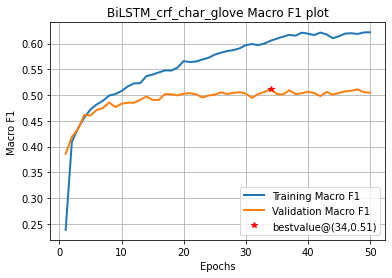

PERFORMANCE ON Test DATA
MicroF1 = 0.816718054128126
Accuracy = 0.9620807270545624
------------Classification Report-------------
              precision    recall  f1-score   support

         art      0.414     0.118     0.183       102
         eve      0.417     0.345     0.377        87
         geo      0.838     0.877     0.857      9912
         gpe      0.931     0.917     0.924      4168
         nat      0.478     0.400     0.436        55
         org      0.651     0.656     0.654      5205
         per      0.801     0.748     0.774      4406
         tim      0.879     0.862     0.870      5275

   micro avg      0.817     0.816     0.817     29210
   macro avg      0.676     0.615     0.634     29210
weighted avg      0.816     0.816     0.816     29210

